In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# from tensorflow.keras.datasets import mnist
# from tensorflow import keras
# import tensorflow.keras.backend as K
# from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout
# from tensorflow.keras.layers import concatenate

In [21]:
dataset = pd.read_csv('predictive_maintenance.csv').drop(columns=['Product ID'])

product_type_dir = {
    'L': 0,
    'M': 1,
    'H': 2
}

dataset = dataset.replace(to_replace=product_type_dir)

fail_types = set(dataset.loc[:,'Failure Type'])
# 60-25-15 тренировка-тест-валидация
train_data, test_data, validation_data = pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([])
for x in fail_types:
    x_fails = dataset[dataset['Failure Type'] == x]
    if x != "No Failure":
        tr, ts, val = np.split(x_fails, [round(0.6*len(x_fails)), round(0.85*len(x_fails))])
    else:
        tr, ts, val = np.split(x_fails, [round(0.6*len(x_fails)), round(0.85*len(x_fails))+1])
    train_data = pd.concat([train_data, tr], ignore_index=True)
    test_data = pd.concat([test_data, ts], ignore_index=True)
    validation_data = pd.concat([validation_data, val], ignore_index=True)
train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)
validation_data = validation_data.sample(frac=1)

fail_types_dir = {
    'No Failure': 0,
    'Overstrain Failure': 1,
    'Heat Dissipation Failure': 2,
    'Power Failure': 3,
    'Random Failures': 4,
    'Tool Wear Failure': 5
}

train_output = train_data['Failure Type'].apply(lambda x: fail_types_dir[x])
test_output = test_data['Failure Type'].apply(lambda x: fail_types_dir[x])
validation_output = validation_data['Failure Type'].apply(lambda x: fail_types_dir[x])

# train_output = fail_types_dir[train_data['Failure Type']]
# test_output = test_data['Failure Type']
# validation_output = validation_data['Failure Type']

train_data = train_data.drop(columns=['Target', 'Failure Type'])
test_data = test_data.drop(columns=['Target', 'Failure Type'])
validation_data = validation_data.drop(columns=['Target', 'Failure Type'])

In [22]:
train_data.iloc[:,2:] = train_data.iloc[:,2:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
test_data.iloc[:,2:] = test_data.iloc[:,2:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
validation_data.iloc[:,2:] = validation_data.iloc[:,2:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [23]:
hidden_dim = 10
num_classes = 6
batch_size = 100

train_data = np.reshape(np.array(train_data), (len(train_data), 7))
test_data = np.reshape(np.array(test_data), (len(test_data), 7))
validation_data = np.reshape(np.array(validation_data), (len(validation_data), 7))

train_data_cat = keras.utils.to_categorical(train_output, 6)
test_data_cat = keras.utils.to_categorical(test_output, 6)
validation_data_cat = keras.utils.to_categorical(validation_output, 6)

In [24]:
train_data.shape

(6000, 7)

In [25]:
def dropout_and_batch(x):
  return keras.layers.Dropout(0.3)(keras.layers.BatchNormalization()(x))

input_row = keras.layers.Input(shape=(7,))
label = keras.layers.Input(shape=(num_classes,))
x = keras.layers.concatenate([input_row, label])
x = keras.layers.Dense(100, activation='relu')(x)
x = dropout_and_batch(x)
x = keras.layers.Dense(50, activation='relu')(x)
x = dropout_and_batch(x)

# mean
z_mean2 = keras.layers.Dense(hidden_dim)(x)
# log(dispersion)
z_log_var = keras.layers.Dense(hidden_dim)(x)

def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  # generate gaussian random values
  N = keras.backend.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
  # sigma*N+Mu
  return keras.backend.exp(z_log_var / 2) * N + z_mean

# latent space vector h
h = keras.layers.Lambda(noiser, output_shape=(hidden_dim,))([z_mean2, z_log_var])

input_dec = keras.layers.Input(shape=(hidden_dim,))
lb_dec = keras.layers.Input(shape=(num_classes,))
d = keras.layers.concatenate([input_dec, lb_dec])
d = keras.layers.Dense(50, activation='elu')(d)
d = dropout_and_batch(d)
d = keras.layers.Dense(100, activation='elu')(d)
d = dropout_and_batch(d)
decoded = keras.layers.Dense(7, activation='softmax')(d)

encoder = keras.Model([input_row, label], h, name='encoder')
decoder = keras.Model([input_dec, lb_dec], decoded, name='decoder')
cvae = keras.Model([input_row, label, lb_dec], decoder([encoder([input_row, label]), lb_dec]), name="cvae")


z_meaner = keras.Model([input_row, label], z_mean2)
tr_style = keras.Model([input_row, label, lb_dec], decoder([z_meaner([input_row, label]), lb_dec]), name='tr_style')

In [26]:
def vae_loss(x, y):
  x = keras.backend.reshape(x, shape=(batch_size, 7))
  y = keras.backend.reshape(y, shape=(batch_size, 7))
  loss = keras.backend.sum(keras.backend.square(x-y), axis=-1)
  kl_loss = -0.5 * keras.backend.sum(1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var), axis=-1)
  return (loss + kl_loss)/2/7

# keras.optimizers.Adam()
cvae.compile(optimizer='adam', loss=vae_loss)

In [28]:
cvae.fit([train_data, train_data_cat, train_data_cat], train_data, epochs=10, batch_size=batch_size, shuffle=True)

Epoch 1/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.3750
Epoch 2/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.5625
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.5625
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.3750
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.5625
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.6250
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.3750
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.3750
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.6250
Epoch 10/10
60/60 [==============================] - 0s 2ms/step - loss: 865510.5625


100/100 [==============================] - 0s 1ms/step


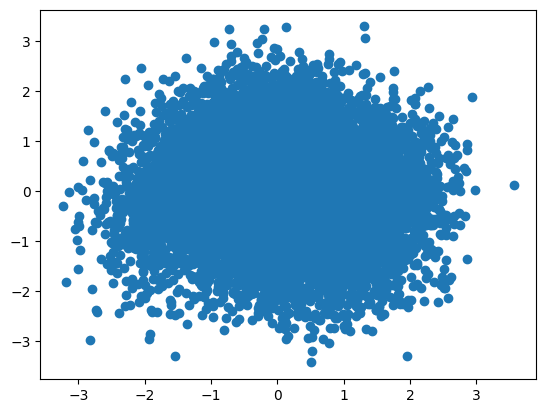

In [6]:
lb = lb_dec = y_test_cat
h = encoder.predict([x_test, lb], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])

1/1 [==============================] - 0s 19ms/step


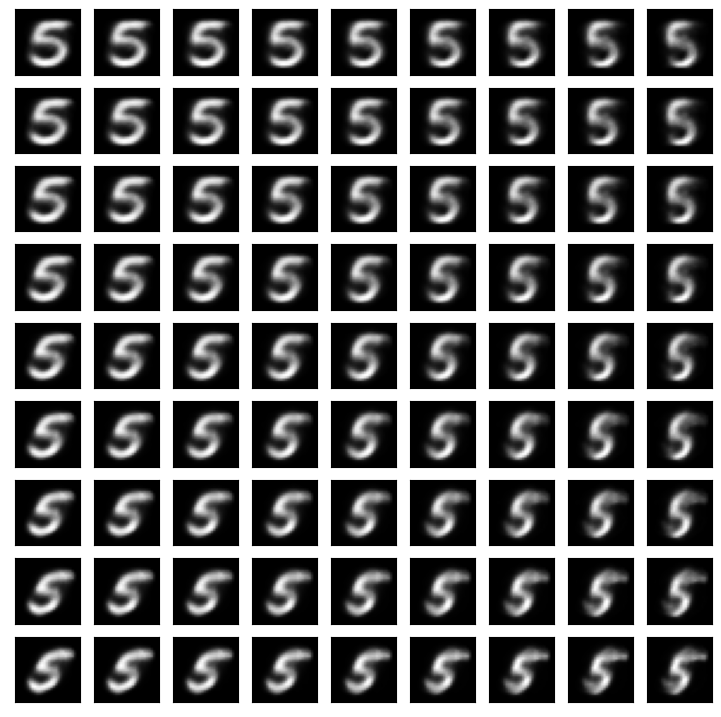

In [7]:
n = 4
total = 2*n+1
input_lbl = np.zeros((1, num_classes))
input_lbl[0, 5] = 1

plt.figure(figsize=(total, total))

h = np.zeros((1, hidden_dim))
num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    h[0, :] = [1*i/n, 1*j/n]
    img = decoder.predict([h, input_lbl])
    plt.imshow(img.squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

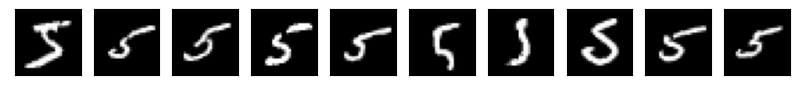

1/1 [==============================] - 0s 103ms/step


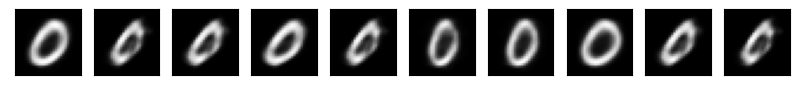

1/1 [==============================] - 0s 14ms/step


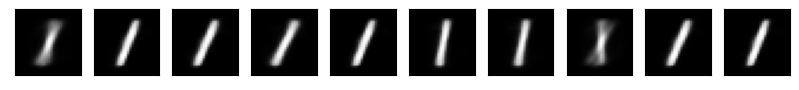

1/1 [==============================] - 0s 15ms/step


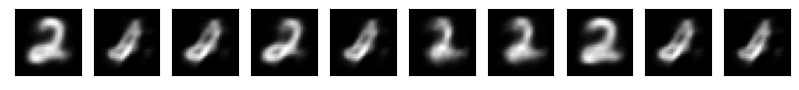

1/1 [==============================] - 0s 16ms/step


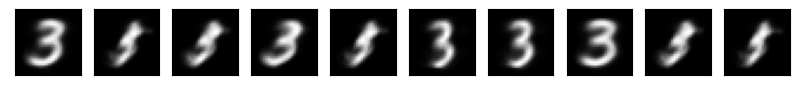

1/1 [==============================] - 0s 15ms/step


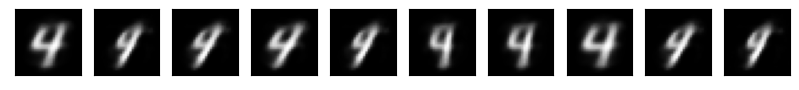

1/1 [==============================] - 0s 16ms/step


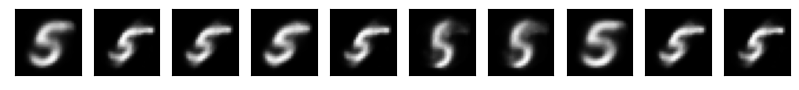

1/1 [==============================] - 0s 16ms/step


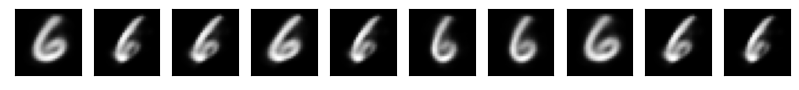

1/1 [==============================] - 0s 16ms/step


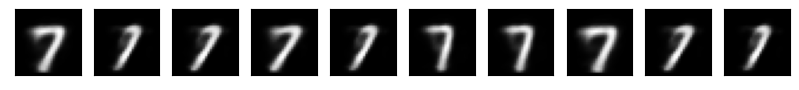

1/1 [==============================] - 0s 15ms/step


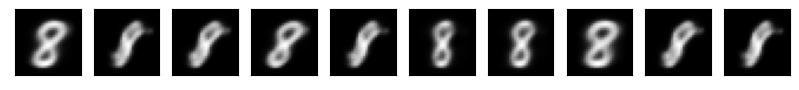

1/1 [==============================] - 0s 17ms/step


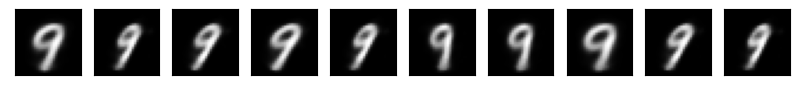

In [8]:
def plot_digits(*images):
    images = [x.squeeze() for x in images]
    n = min([x.shape[0] for x in images])
    
    plt.figure(figsize=(n, len(images)))
    for j in range(n):
        for i in range(len(images)):
            ax = plt.subplot(len(images), n, i*n + j + 1)
            plt.imshow(images[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

dig1 = 5
dig2 = 2

num = 10
X = x_train[y_train == dig1][:num]

lb_1 = np.zeros((num, num_classes))
lb_1[:, dig1] = 1

plot_digits(X)

for i in range(num_classes):
  lb_2 = np.zeros((num, num_classes))
  lb_2[:, i] = 1

  Y = tr_style.predict([X, lb_1, lb_2], batch_size=num)
  plot_digits(Y)